# Setup

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns

from network import Net, NetDiscovery
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()
torch.manual_seed(42)
np.random.seed(10)

# Variables & Training/Equation Data

Text(0.5, 0, 'Time (s)')

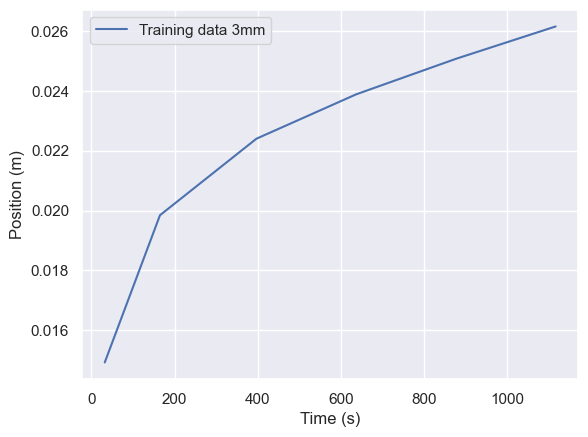

In [2]:
# Different variables for problem
r = 0.003                           # Radius of droplet in [m]
V = (4/3)*np.pi*(r**3)              # Volume of droplet in [m^3]
mu_0 = 1.256637*(10**-6)            # Permeability of free space [m*kg/(s*A)]
eta = 50                            # Viscosity in [Pa*s]
M = magnetization                   # Magnetization in [Oe]
H = magnetic_field                  # Magnetic field in [KA/m]
dH_dx = magnetic_field_deriv        # Derivative of magnetic field with respect to distance in [KA/m^2]
n = 6                               # Number of data points

# Grab training data
train_t, train_x = position_3mm_droplet()

# Plot training data
plt.plot(train_t, train_x)
plt.legend(['Training data 3mm'])
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')

# Physics Loss Model

In [3]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1200, steps=1200,).view(-1, 1).requires_grad_(True).to(DEVICE)
    xs = model(ts)
    dx = grad(xs, ts)[0]
    pde = (V*M(xs)*mu_0*dH_dx(xs))/(6*r*np.pi*eta) - dx
    
    return torch.mean(pde**2)
    

# Trying Different Loss Weights for Physics Loss + Data Loss

In [ ]:
# different_lambdas = torch.linspace(0, 500, 25)
# losses_each_lambda = torch.empty(len(different_lambdas))

# for i in range(0, len(different_lambdas)):
#     net = Net(1,1, loss2=physics_loss, epochs=5000, loss2_weight=different_lambdas[i], lr=0.5).to(DEVICE)
#     losses_each_lambda[i] = net.fit(train_t, train_x)[-1]

# plt.plot(different_lambdas, losses_each_lambda)
# plt.legend(['Loss vs. Lambda'])
# plt.ylabel('Loss')
# plt.xlabel('Lambda')

# Learn the Model

In [8]:
net = Net(1, 1, loss2=physics_loss, epochs=2000, loss2_weight=1, lr=1e-3).to(DEVICE)
losses = net.fit(train_t, train_x)
plt.plot(losses)
plt.yscale('log')

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

[[0.08759427]
 [0.9994    ]
 [0.7575567 ]
 ...
 [5.441771  ]
 [5.446279  ]
 [5.4507737 ]]


Text(0.5, 0, 'Time (s)')

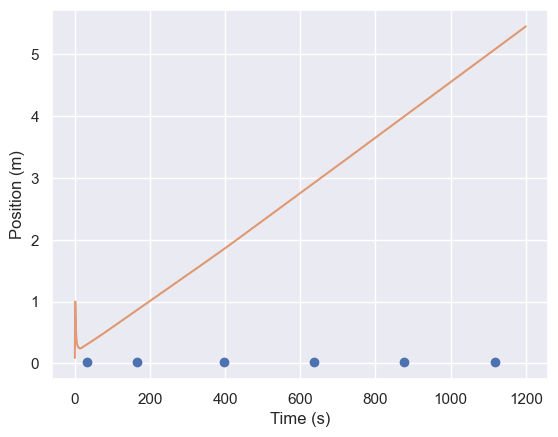

In [ ]:
times = np.linspace(0, 1200, 1200)
preds = net.predict(times)
print(preds)

plt.plot(train_t, train_x, 'o')
plt.plot(times, preds, alpha=0.8)
plt.ylabel('Position (m)')
plt.xlabel('Time (s)')